In [1]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

c:\Users\Sirikit Joshi\.conda\envs\cudaenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [18]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [10]:
import pandas as pd
data_raw = pd.read_csv("./dataset/translation.csv")
data_raw

,Unnamed: 0,english,Unnamed: 2,रन
0,0.0,Run,NaN,रन
1,1.0,Run,NaN,रन
2,2.0,Wow,NaN,वाह
3,3.0,Fire,NaN,आगो
4,4.0,Help,NaN,सहायता
...,...,...,...,...
136836,NaN,NaN,NaN,NaN
136837,NaN,NaN,NaN,NaN
136838,NaN,NaN,NaN,NaN
136839,NaN,NaN,NaN,NaN


In [11]:
data_raw.dropna(inplace=True)
data_raw.tail()

,Unnamed: 0,english,Unnamed: 2,रन


#2. EDA

In [12]:
dataset = data_raw.values.tolist()
dataset_size = len(dataset)
dataset_size

0

In [13]:
random.shuffle(dataset)
train_data_set_size = int(dataset_size *0.9)

train_dataset = dataset[:train_data_set_size]
test = dataset[train_data_set_size:]

train_size = int(train_data_set_size *0.9)
train = train_dataset[:train_size]
val = train_dataset[train_size:]

In [14]:
len(train),len(val),len(test)

(0, 0, 0)

#3.Preprocessing

In [15]:
SRC_LANGUAGE = 'np'
TRG_LANGUAGE = 'en'
# Place-holders
token_transform = {}
vocab_transform = {}

In [16]:
from attacut import tokenize, Tokenizer
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = Tokenizer(model="attacut-sc")
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [17]:
#example of tokenization of the nepali part
print("Sentence: ", train[0][1])
print("Tokenization: ", token_transform[SRC_LANGUAGE].tokenize(train[0][1]))

IndexError: list index out of range

In [ ]:
#example of tokenization of the english part
print("Sentence: ", train[0][0])
print("Tokenization: ", token_transform[SRC_LANGUAGE].tokenize(train[0][0]))

IndexError: list index out of range

In [ ]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        if language == SRC_LANGUAGE:
            yield token_transform[language].tokenize(data_sample[language_index[language]])
        elif language == TRG_LANGUAGE:
            yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [ ]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [ ]:
import pickle
with open('vocab.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(vocab_transform, file)

In [ ]:
import pickle
with open('nepali_vocab.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(vocab_transform[TRG_LANGUAGE], file)

In [ ]:
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[0, 0, 0, 0, 0]

In [ ]:
vocab_transform[TRG_LANGUAGE](['उहाँले', 'एक', 'हो '])

[0, 0, 0]

In [ ]:
#we can reverse its English....
mapping = vocab_transform[TRG_LANGUAGE].get_itos()
# #print 1816, for example
mapping[400]

IndexError: list index out of range

In [ ]:
#we can reverse its Thailand....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()
# #print 1816, for example
mapping[400]

' has'

In [ ]:
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

#4. Preparing the dataloader
One thing we change here is the <B>collate_fn</B> which now also returns the length of sentence. This is required for <B>packed_padded_sequence</B>

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import multiprocessing as mp
BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    global func
    def func(txt_input):
        for transform in transforms:
            if transform == token_transform[SRC_LANGUAGE]:
                txt_input = transform.tokenize(txt_input)
            else:
                txt_input = transform(txt_input)
        return txt_input

    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    import pickle
        
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [ ]:
text_transform


{'np': <function __main__.func(txt_input)>,
 'en': <function __main__.func(txt_input)>}

#Create train, val, and test dataloaders

In [ ]:
batch_size = 32

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
for np, _, en in train_loader:
    break

In [ ]:
print("nepali shape: ", np.shape)  # (seq len, batch_size)
print("English shape: ", en.shape)   # (seq len, batch_size)

nepali shape:  torch.Size([16, 32])
English shape:  torch.Size([9, 32])


In [ ]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [ ]:
print(train_loader_length)
print(val_loader_length)
print(test_loader_length)

2604
290
322


In [ ]:
train_loader_length = 3439
val_loader_length = 383
test_loader_length = 425

In [ ]:
train_loader_length, val_loader_length, test_loader_length  

(3439, 383, 425)

#5. Design the model
##Encoder
The changes here all within the forward method. It now accepts the lengths of the source sentences as well as the sentences themselves.

After the source sentence (padded automatically within the iterator) has been embedded, we can then use pack_padded_sequence on it with the lengths of the sentences. Note that the tensor containing the lengths of the sequences must be a CPU tensor as of the latest version of PyTorch, which we explicitly do so with to('cpu'). packed_embedded will then be our packed padded sequence. This can be then fed to our RNN as normal which will return packed_outputs, a packed tensor containing all of the hidden states from the sequence, and hidden which is simply the final hidden state from our sequence. hidden is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final non-padded element in the sequence.

We then unpack our packed_outputs using pad_packed_sequence which returns the outputs and the lengths of each, which we don't need.

The first dimension of outputs is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn       = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc        = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout   = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src: [src len, batch size]
        #src len: [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                            src_len.to('cpu'), enforce_sorted=False)
        
        #packed_outputs contain all hidden states including padding guy
        #hidden contains the last hidden states of the non-padded guys
        packed_outputs, hidden = self.rnn(packed_embedded)
        #hidden: [n layers * num directions, batch size, hid dim]
        
        #convert packed_outputs to the guy that does not contain hidden states for padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #outputs: [src len, batch size, hid dim * num directions]
        
        #take the last hidden states from backward and forward
        #hidden: (f, b, f, b)
        forward  = hidden[-2, :, :]  #[batch size, hid dim]
        backward = hidden[-1, :, :]  #[batch size, hid dim]
        
        hidden = torch.tanh(self.fc(torch.cat((forward, backward), dim = 1))) 
        #hidden: [batch size, hid dim]
        
        return outputs, hidden

#Attention
The attention used here is additive attention which is defined by:

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using masking, we can force the attention to only be over non-padding elements.

The forward method now takes a mask input. This is a [batch size, source sentence length] tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: ["hello", "how", "are", "you", "?",,], then the mask would be [1, 1, 1, 1, 1, 0, 0].

We apply the mask after the attention has been calculated, but before it has been normalized by the softmax function. It is applied using masked_fill. This fills the tensor at each element where the first argument (mask == 0) is true, with the value given by the second argument (-1e10). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be -1e10. As these numbers will be miniscule compared to the other values they will become zero when passed through the softmax layer, ensuring no attention is payed to padding tokens in the source sentence.

In [ ]:
class Attention(nn.Module):
    def __init__(self, hid_dim, variants):
        super().__init__()
        self.variants = variants
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim,     hid_dim) #for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]

        if self.variants == 'additive': #work
            #repeat decoder hidden state src_len times
            hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
            #hidden = [batch size, src len, hid dim]
            
            energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))
            #energy = [batch size, src len, hid dim]
            
            attention = self.v(energy).squeeze(2)
            #attention = [batch size, src len]
            
        elif self.variants == 'general': #work
            hidden = hidden.unsqueeze(1).repeat(1, 1, 2)
            #hidden = [batch size, 1, hid dim*2]
            #encoder_outputs = [batch size, hid dim * 2, src len]

            energy = torch.bmm(hidden, encoder_outputs.transpose(1, 2))
            attention = energy.squeeze(1)
            #attention = [batch size, src len]

        elif self.variants == 'multiplicative':
            wh = self.W(hidden).unsqueeze(1).repeat(1, 1, 2)
            #wh = [batch size, 1, hid dim*2]
            #encoder_outputs = [batch size, hid dim * 2, src len]

            energy = torch.bmm(wh, encoder_outputs.transpose(1, 2))
            attention = energy.squeeze(1)

        #use masked_fill_ if you want in-place
        attention = attention.masked_fill(mask, -1e10)
        #attention = [batch size, src len]
        return F.softmax(attention, dim = 1)

In [ ]:
#example of masked_fill
#reall that 1 is pad_idx
x = torch.tensor([ [9, 1, 7, 2, 1, 1], [99, 1, 1, 0, 8, 9] ])

mask = (x == PAD_IDX)

x.masked_fill_(mask, -1e10)
print(x)

tensor([[           9, -10000000000,            7,            2, -10000000000,
         -10000000000],
        [          99, -10000000000, -10000000000,            0,            8,
                    9]])


#Decoder
The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        
        #input = [batch size]
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch size, src len]

        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs) #Ct
        #weighted = [batch size, 1, hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input = [1, batch size, (hid dim * 2) + emb dim]
        
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [1, batch size, hid dim]
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output   = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [ ]:
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        #src: [src len, batch size]
        
        mask = (src == self.src_pad_idx).permute(1, 0)
        #mask: [batch size, src len]
        #we need to permute to make the mask same shape as attention...
        return mask

        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src: [src len, batch size]
        #src len: [batch size]
        #trg: [trg len, batch size]
        
        batch_size = src.shape[1]
        trg_len    = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim #define in decoder
        
        #because decoder decodes each step....let's create a list that gonna append the result to this guy
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #because decoder decodes each step....let's memorize the attention done in each step....
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #let's start!!!
        #1. encoder
        encoder_outputs, hidden = self.encoder(src, src_len)
        #encoder_outputs: [src len, batch size, hid dim * num directions]
        #hidden: [batch size, hid dim]
        
        #set the first input to the decoder
        input_ = trg[0,:]  #basically <sos>
        
        #create the mask for use in this step
        mask = self.create_mask(src)
        
        #2. for each of trg word
        for t in range(1, trg_len):

            #3. decode (hidden is always carry forward)
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output:   [batch size, output_dim]
            #hidden:   [batch size, hid_dim]
            #attention::[batch size, src len]  ==> how each of src token is important to input_ 
            
            #4. append the results to outputs and attentions
            outputs[t] = output
            attentions[t] = attention
            
            #5. get the result, using argmax
            top1 = output.argmax(1)  #find the maximum index of dimension 1, which is output_dim
            
            #6. based on the teacher forcing ratio, 
            teacher_force_or_not = random.random() < teacher_forcing_ratio
                    #if teacher forcing, next input is the next trg
                    #if no teacher forcing, the next input is the argmax guy...
            input_ = trg[t] if teacher_force_or_not else top1  #autoregressive
            
        return outputs, attentions #outputs for predicting the word, attentions to see which word is important

In [ ]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [ ]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim, variants='additive')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model_additive = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model_additive.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(7585, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(6766, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=6766, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model_additive)

1941760
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
1732096
1966080
786432
  1536
  1536
12124672
  6766
______
22239086


In [ ]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model_additive.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

In [ ]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [ ]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'/content/{model_additive.__class__.__name__}_fullSCB.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model_additive, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model_additive, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_additive.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 5m 26s
	Train Loss: 2.479 | Train PPL:  11.929
	 Val. Loss: 1.532 |  Val. PPL:   4.627
Epoch: 02 | Time: 5m 19s
	Train Loss: 1.122 | Train PPL:   3.070
	 Val. Loss: 1.136 |  Val. PPL:   3.113
Epoch: 03 | Time: 5m 11s
	Train Loss: 0.752 | Train PPL:   2.121
	 Val. Loss: 1.009 |  Val. PPL:   2.744
Epoch: 04 | Time: 5m 11s
	Train Loss: 0.585 | Train PPL:   1.794
	 Val. Loss: 1.006 |  Val. PPL:   2.735
Epoch: 05 | Time: 5m 10s
	Train Loss: 0.489 | Train PPL:   1.631
	 Val. Loss: 0.991 |  Val. PPL:   2.693


Text(0, 0.5, 'loss')

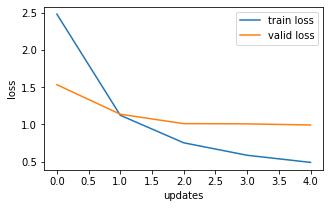

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [ ]:
model_additive.load_state_dict(torch.load(save_path))
test_loss = evaluate(model_additive, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.971 | Test PPL:   2.642 |


#7. Test on some random dataset

In [ ]:
dataset[0][0], dataset[0][1]

('Some boats are on the lake', 'केही डुङ्गाहरु ताल छन्')

In [ ]:
src_text = text_transform[SRC_LANGUAGE](dataset[0][0]).to(device)
trg_text = text_transform[TRG_LANGUAGE](dataset[0][1]).to(device)
src_text, trg_text

(tensor([   2,  813,    4, 4391,    4,   42,    4,   48,    4,   10,    4, 1202,
            3], device='cuda:0'),
 tensor([   2,   47,    0, 1120,   31,    3], device='cuda:0'))

In [ ]:
src_text = src_text.reshape(-1, 1)  #because batch_size is 1
trg_text = trg_text.reshape(-1, 1)
src_text.shape, trg_text.shape

(torch.Size([13, 1]), torch.Size([6, 1]))

In [ ]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [ ]:
model_additive.load_state_dict(torch.load(save_path))

model_additive.eval()
with torch.no_grad():
    output, attentions = model_additive(src_text, text_length, trg_text, 0) #turn off teacher forcing

In [ ]:
output.shape #trg_len, batch_size, trg_output_dim

torch.Size([6, 1, 6766])

In [ ]:
output = output.squeeze(1)
output.shape

torch.Size([6, 6766])

In [ ]:
output_max = output.argmax(1) #returns max indices
output_max

tensor([   0,   47,    0, 1120,   31,    3], device='cuda:0')

In [ ]:
for token in output_max:
    print(mapping[token.item()])

<unk>
What
<unk>
stuck
want
<eos>


#8. Attention

In [ ]:

attentions.shape

torch.Size([6, 1, 13])

In [ ]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE].tokenize(dataset[0][1]) + ['<eos>']
src_tokens

['<sos>',
 'क',
 'े',
 'ह',
 'ी ',
 'ड',
 'ु',
 'ङ्गा',
 'ह',
 'र',
 'ु ',
 'त',
 'ा',
 'ल ',
 'छ',
 'न',
 '्',
 '<eos>']

In [ ]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>', '<unk>', 'What', '<unk>', 'stuck', 'want', '<eos>']

In [ ]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

<ipython-input-74-b23710e830bc>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-74-b23710e830bc>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from 

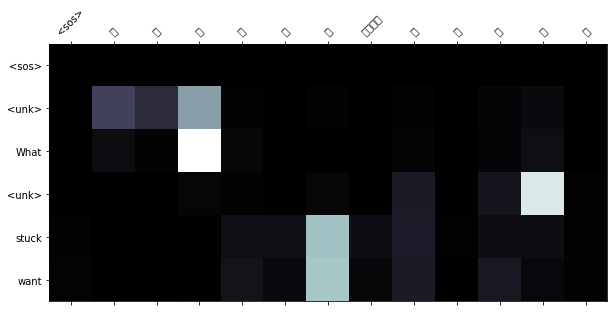

In [ ]:
display_attention(src_tokens, trg_tokens, attentions)